In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Generate SQL filter

In [68]:
barcodes_df = pd.read_csv('barcodes.csv')
start_date = '2023-01-09'
end_date = '2023-03-24'
time_filter = f"(\"Loan Details\".\"Loan Date\" BETWEEN date '{start_date}' AND date '{end_date}')"
barcode_filter = f"\"Loan Details\".\"Barcode\" LIKE '{barcodes_df['Barcode'][0]}%'"
for barcode in barcodes_df['Barcode'][1:]:
    barcode_filter += f" OR \"Loan Details\".\"Barcode\" LIKE '{barcode}%'"

barcode_filter = '(' + barcode_filter + ')'
SQL_filter = time_filter + ' AND ' + barcode_filter
print(SQL_filter)

("Loan Details"."Loan Date" BETWEEN date '2023-01-09' AND date '2023-03-24') AND ("Loan Details"."Barcode" LIKE 'HP%' OR "Loan Details"."Barcode" LIKE 'CBK%' OR "Loan Details"."Barcode" LIKE 'MP%' OR "Loan Details"."Barcode" LIKE 'CLICC-ML%' OR "Loan Details"."Barcode" LIKE 'CLICC-MM%' OR "Loan Details"."Barcode" LIKE 'FAC%' OR "Loan Details"."Barcode" LIKE 'IPADK%' OR "Loan Details"."Barcode" LIKE 'ANDROID%' OR "Loan Details"."Barcode" LIKE 'IPHONE%' OR "Loan Details"."Barcode" LIKE 'BOEIPHONE%' OR "Loan Details"."Barcode" LIKE 'MACCHRG%' OR "Loan Details"."Barcode" LIKE 'OLDMACCHRG%' OR "Loan Details"."Barcode" LIKE 'MACUSBC%' OR "Loan Details"."Barcode" LIKE 'HPUSBC%' OR "Loan Details"."Barcode" LIKE 'WALLADPT%' OR "Loan Details"."Barcode" LIKE 'ANKER%' OR "Loan Details"."Barcode" LIKE 'OMNI%' OR "Loan Details"."Barcode" LIKE 'VGA%' OR "Loan Details"."Barcode" LIKE 'BIOUSBCVGA%' OR "Loan Details"."Barcode" LIKE 'UVGA%' OR "Loan Details"."Barcode" LIKE 'HDMIC%' OR "Loan Details"."Bar

## Transform raw data

In [69]:
# Convert the date and time columns to datetime objects
raw_df = pd.read_csv('raw_norenew_230402.csv')
raw_df['Loan Datetime'] = [datetime.strptime(date_str + ' ' + time_str, '%Y-%m-%d %H:%M:%S') for date_str, time_str in zip(raw_df['Loan Date'], raw_df['Loan Time'])]
raw_df['Return Datetime'] = [np.nan if pd.isnull(date_str) else datetime.strptime(date_str + ' ' + time_str, '%Y-%m-%d %H:%M:%S') for date_str, time_str in zip(raw_df['Return Date'], raw_df['Return Time'])]
raw_df = raw_df.drop(['Loan Date', 'Loan Time', 'Return Date', 'Return Time'], axis=1)

In [70]:
# Add loan duration column
raw_df['Loan Duration'] = raw_df['Return Datetime'] - raw_df['Loan Datetime']

In [71]:
# Add general patron group column
print(raw_df['Patron Group'].unique()) # Check if the unique values correspond to the patron groups in the patrons.csv file
patrons_df = pd.read_csv('patrons.csv')
patrons_dict = {group: general for group, general in zip(patrons_df['Patron Group'], patrons_df['General Patron Group'])}
raw_df['General Patron Group'] = [patrons_dict[group] for group in raw_df['Patron Group']]

['UCLA Graduate' 'UCLA Undergrad' 'UCLA Music Grad' 'UCLA Music Undergrad'
 'UCLA Staff' 'UCLA Academic' 'UCLA Mgmt PhD' 'External 10 - UCLA Alumni'
 'UCLA Law Academic' 'NETWORK' 'UCLA Law Grad' 'Extension'
 'UCLA Grad NoLimit' 'Access Only' 'External 10']


In [72]:
# Add item type, general item type and item policy columns

barcode_prefixes = [re.sub(r'\d+$', '', s) for s in raw_df['Barcode']]
print(set(barcode_prefixes)) # Check if the prefixes correspond to the prefixes in the barcodes.csv file
item_types = []
general_item_types = []
item_policies = []
for barcode in raw_df['Barcode']:
    for i, bc in enumerate(barcodes_df['Barcode']):
        if barcode.startswith(bc):
            item_types.append(barcodes_df['Item Type'][i])
            general_item_types.append(barcodes_df['General Item Type'][i])
            item_policies.append(barcodes_df['Item Policy'][i])
            break
raw_df['Item Type'] = item_types
raw_df['General Item Type'] = general_item_types
raw_df['Item Policy'] = item_policies
raw_df = raw_df.drop(['Policy Name', 'Description'], axis=1)

{'BIOUSBCVGA', 'MACUSBC19C', 'CBK-', 'MACUSBC13C', 'UHDMI', 'ANKER', 'MP-', 'MACUSBC29C', 'HDST', 'BOEIPHONE', 'MACUSBC06C', 'MACUSBC07C', 'ANDROID', 'UVGA', 'IPADK', 'MP', 'HDMIC', 'FAC', 'SUP-', 'AD', 'MACUSBC25C', 'OMNI', 'MACUSBC27C', 'MACUSBC23C', 'MSE', 'MACUSBC05C', 'MACUSBC09C', 'MACCHRG', 'CLICC-MM-', 'HP', 'HPUSBC', 'MACUSBC17C', 'CBK', 'MP092C', 'MACUSBC16C', 'MACUSBC12C', 'SUP', 'HP076C', 'VGAC', 'VGA', 'IPHONE', 'CLICC-ML-', 'MACUSBC', 'MACUSBC24C', 'CALC', 'LABMSE', 'HP-', 'MACUSBC08C', 'OLDMACCHRG', 'MACUSBC20C', 'WALLADPT'}


In [75]:
# Uncomment the following line to check transformation results
# raw_df.head()
# raw_df.to_csv('raw_df.csv', index=False)

## Calculations

1. Of all CLICC transactions listed in Alma for fall quarter, what % were the "chromebook" type (1-2 weeks) and what % were the "small item" type (6 hours)

In [63]:
total_loans = raw_df.shape[0]
num_7d = raw_df[raw_df['Item Policy'] == '7d'].shape[0]
per_7d = num_7d / total_loans
num_6h = raw_df[raw_df['Item Policy'] == '6h'].shape[0]
per_6h = num_6h / total_loans
print(total_loans, per_7d, per_6h)

7084 0.40245623941276115 0.5755223037831734


2. Of all the small item type loans (6 hours) what was the average loan length for patrons - % breakdown could also be shown, ie 24% < 2 hours, 35% between 2 - 4 hours, the rest >6 hours

In [87]:
small_df = raw_df[raw_df['Item Policy'] == '6h']
small_df_returned = small_df[small_df['Loan Duration'].notnull()]

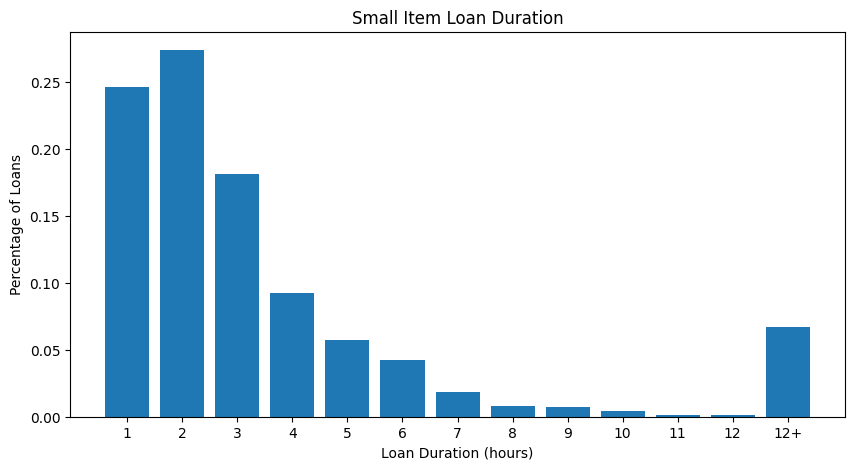

In [131]:
total_seconds = small_df_returned['Loan Duration'].dt.total_seconds().astype(int)
bins = [*range(0, 3600*13, 3600), total_seconds.max()]
bin_counts = pd.cut(total_seconds, list(bins)).value_counts(sort=False)
bin_percents = bin_counts / total_seconds.shape[0]
bins = [str(i) for i in range(1, 13)]
bins.append('12+')

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(bins, bin_percents)
plt.xlabel('Loan Duration (hours)')
plt.ylabel('Percentage of Loans')
plt.title('Small Item Loan Duration')
plt.show()